In [15]:
import sys
import pandas as pd

#!/usr/bin/python3

%load_ext autoreload
%autoreload 2

from run import run_TSens, run_Elastic, run_LTSens, run_Query, run_PrivateSQL, run_TSensDP
from algo import gen_report_title, gen_query_report_title
from objects import Relation
from dp import DP_TSens, DP_PrivateSQL
import dp
from import_schema import read_schema_from_file
from import_hypertree import read_hypertree_from_file

scale = '1'

#top_triangles_csv = './data/snap/facebook/top_triangles.csv'
#top_triangles = pd.read_csv(top_triangles_csv)

def iterate_queries(plat, qtype):
    import os
    query_folder = './queries/snap_%s/'%plat
    queries = []
    for filename in os.listdir(query_folder):
        if filename[0] != 'q':
            continue
        qname = filename.strip().split('.')[0]
        qfullname = open(query_folder + filename, 'r').readline().strip().split(' ')[1]
        q = (qname, qfullname)
        if qtype == 'all':
            queries.append(q)
        else:
            qmark = qname.split('_')[1]
            if qtype == qmark:
                queries.append(q)
    return queries
    
def run_sens(plat, qtype = 'all', reps=1):
    old_stdout = sys.stdout
    sys.stdout = open('/tmp/report', 'w')
    gen_report_title()
    for qname, qfullname in iterate_queries(plat, qtype):
        arch = 'snap_%s'%plat
        run_TSens(arch, scale, q=qname, reps=reps, report='file')
        run_Elastic(arch, scale, q=qname, reps=reps, report='file')
    sys.stdout = old_stdout
    report = pd.read_csv('/tmp/report', sep=r' \| ', engine='python')
    return report

def run_query(plat, qtype = 'all', reps=1):
    old_stdout = sys.stdout
    sys.stdout = open('/tmp/report', 'w')
    gen_query_report_title()
    for qname, qfullname in iterate_queries(plat, qtype):
        arch = 'snap_%s'%plat
        run_Query(arch, scale, q=qname, reps=reps, report='query')
    sys.stdout = old_stdout
    report = pd.read_csv('/tmp/report', sep=r' \| ', engine='python')
    return report

limit_dict = {
    '4star': 15,
    'triangle': 70,
    '4cycle': 200,
    '4path': 25000
}

def run_DP(plat, qtype = 'all', reps=1):
    old_stdout = sys.stdout
    sys.stdout = open('/tmp/report', 'w')
    dp.gen_report_title()
    for qname, qfullname in iterate_queries(plat, qtype):
        arch = 'snap_%s'%plat
        limit = limit_dict[qname.split('_')[1]]
        eps = 1.0
        exclusion = []
        # Be careful ... it only works when each table is about source and circle ...
        source = qfullname.split('_')[2]
        circle = qfullname.split('_')[4]
        reln = Relation('any', 'source_{source}_circle_{circle}'.format(source=source, circle=circle), {})
        #run_LTSens(arch, scale, q=qname, exclusion=exclusion, report=None, reps=1)
        run_TSensDP(arch, scale, qname, reln, limit, eps, report='file', reps=reps)
        run_PrivateSQL(arch, scale, qname, reln, None, eps, report='file', reps=reps)
    sys.stdout = old_stdout
    report = pd.read_csv('/tmp/report', sep=r' \| ', engine='python')
    return report 

limits_dict = {
    '4star': [1, 10, 30, 50, 100, 1000],
    'triangle': [1, 10, 30, 50, 100, 1000],
    '4cycle': [10, 100, 500, 1000, 1500, 10000],
    '4path': [100, 10000, 20000, 30000, 50000, 100000],
}
def run_DP_limits(plat, qtype = 'all', reps=1):
    old_stdout = sys.stdout
    sys.stdout = open('/tmp/report', 'w')
    dp.gen_report_title()
    for qname, qfullname in iterate_queries(plat, qtype):
        arch = 'snap_%s'%plat
        for limit in limits_dict[qname.split('_')[1]]:
            eps = 1.0
            exclusion = []
            # Be careful ... it only works when each table is about source and circle ...
            source = qfullname.split('_')[2]
            circle = qfullname.split('_')[4]
            reln = Relation('any', 'source_{source}_circle_{circle}'.format(source=source, circle=circle), {})
            #run_LTSens(arch, scale, q=qname, exclusion=exclusion, report=None, reps=1)
            run_TSensDP(arch, scale, qname, reln, limit, eps, report='file', reps=reps)
    sys.stdout = old_stdout
    report = pd.read_csv('/tmp/report', sep=r' \| ', engine='python')
    return report 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
plat = 'facebook'
qtype = 'all'
reps = 1
report_query = run_query(plat, qtype, reps)
report_query.to_csv('./result/report_query.csv', index=False)

In [19]:
plat = 'facebook'
qtype = 'all'
reps = 20
report_sens = run_sens(plat, qtype, reps)
report_query = run_query(plat, qtype, reps)
report_DP = run_DP(plat, qtype, reps)
report_sens.to_csv('./result/report_sens.csv', index=False)
report_query.to_csv('./result/report_query.csv', index=False)
report_DP.to_csv('./result/report_DP.csv', index=False)

/home/BigDATA/TupleSens/dp.py:13: RuntimeWarning: divide by zero encountered in true_divide
  DIV = Infix(lambda x,y: np.divide(x,y))


In [20]:
plat = 'facebook'
qtype = 'all'
reps = 20
report_DP_limits = run_DP_limits(plat, qtype, reps)
report_DP_limits.to_csv('./result/report_DP_limits.csv', index=False)

In [21]:
report_sens = pd.read_csv('./result/report_sens.csv')
report_query = pd.read_csv('./result/report_query.csv')
report_DP = pd.read_csv('./result/report_DP.csv')
report_DP_limits = pd.read_csv('./result/report_DP_limits.csv')

In [7]:
with pd.option_context("display.width", 100000000, 'display.expand_frame_repr', False):
    display(report_sens.sort_values(['algo', 'query'])[['algo', 'query', 'sensitivity', 'all_table_tstar']])

,algo,query,sensitivity,all_table_tstar
1,Elastic,q_4cycle_60533f,511632,"[(source_348_circle_9939a6, [('D', '563'), ('A..."
5,Elastic,q_4path_b27cc5,511632,"[(source_348_circle_9939a6, [('E', '563'), ('D..."
3,Elastic,q_4star_0ffe47,2723688,"[(source_348_circle_cd20fc, [('C', '376'), ('A..."
7,Elastic,q_triangle_8e3f9d,7524,"[(source_348_circle_cd20fc, [('C', '376'), ('A..."
0,TSens,q_4cycle_60533f,2014,"[(source_348_circle_9939a6, [('d', '376'), ('a..."
4,TSens,q_4path_b27cc5,178923,"[(source_348_circle_cd20fc, [('c', '559'), ('d..."
2,TSens,q_4star_0ffe47,34,"[(source_348_circle_cd20fc, [('c', '378'), ('a..."
6,TSens,q_triangle_8e3f9d,87,"[(source_348_circle_cd20fc, [('c', '561'), ('a..."


In [6]:
with pd.option_context("display.max_rows", 10):
    display(report_sens)

,algo,arch,scale,query,time,relation,tuple,sensitivity,all_table_tstar,time_list,test pass
0,TSens,snap_facebook,1,q_4cycle_60533f,0.627,source_348_circle_9939a6,"[('d', '376'), ('a', '561')]",2014,"[(source_348_circle_9939a6, [('d', '376'), ('a...","[0.6363558769226074, 0.6258268356323242, 0.615...",Succeeded
1,Elastic,snap_facebook,1,q_4cycle_60533f,0.009,source_348_circle_9939a6,"[('D', '563'), ('A', '563')]",511632,"[(source_348_circle_9939a6, [('D', '563'), ('A...","[0.010440587997436523, 0.009118080139160156, 0...",Unknown
2,TSens,snap_facebook,1,q_4star_0ffe47,0.614,source_348_circle_cd20fc,"[('c', '378'), ('a', '561')]",34,"[(source_348_circle_cd20fc, [('c', '378'), ('a...","[0.6282632350921631, 0.5864150524139404, 0.570...",Succeeded
3,Elastic,snap_facebook,1,q_4star_0ffe47,0.012,source_348_circle_cd20fc,"[('C', '376'), ('A', '563')]",2723688,"[(source_348_circle_cd20fc, [('C', '376'), ('A...","[0.013099431991577148, 0.011797189712524414, 0...",Unknown
4,TSens,snap_facebook,1,q_4path_b27cc5,0.253,source_348_circle_cd20fc,"[('c', '559'), ('d', '563')]",178923,"[(source_348_circle_cd20fc, [('c', '559'), ('d...","[0.19710087776184082, 0.20706534385681152, 0.2...",Succeeded
5,Elastic,snap_facebook,1,q_4path_b27cc5,0.012,source_348_circle_9939a6,"[('E', '563'), ('D', '563')]",511632,"[(source_348_circle_9939a6, [('E', '563'), ('D...","[0.030120372772216797, 0.011091947555541992, 0...",Unknown
6,TSens,snap_facebook,1,q_triangle_8e3f9d,0.512,source_348_circle_cd20fc,"[('c', '561'), ('a', '561')]",87,"[(source_348_circle_cd20fc, [('c', '561'), ('a...","[0.5333800315856934, 0.4851827621459961, 0.472...",Succeeded
7,Elastic,snap_facebook,1,q_triangle_8e3f9d,0.007,source_348_circle_cd20fc,"[('C', '376'), ('A', '376')]",7524,"[(source_348_circle_cd20fc, [('C', '376'), ('A...","[0.009356498718261719, 0.007246494293212891, 0...",Unknown


In [8]:
with pd.option_context("display.max_rows", 10):
    display(report_query)

,arch,scale,query,total_output,total_input,total_repr,table_dict,avg_time,time_list,test_pass
0,snap_facebook,1,q_4cycle_60533f,142903,14146,54782,"{'source_348_circle_dabfae': {'cnt': 6830, 'at...",0.450,"[0.5084278583526611, 0.42122840881347656, 0.43...",Unknown
1,snap_facebook,1,q_4star_0ffe47,786,18272,16008,"{'source_348_circle_dabfae': {'cnt': 6830, 'at...",0.176,"[0.1295483112335205, 0.16339111328125, 0.17913...",Unknown
2,snap_facebook,1,q_4path_b27cc5,17555419,14146,27391,"{'source_348_circle_dabfae': {'cnt': 6830, 'at...",0.192,"[0.20009541511535645, 0.1837477684020996, 0.18...",Unknown
3,snap_facebook,1,q_triangle_8e3f9d,30699,13520,62257,"{'source_348_circle_dabfae': {'cnt': 6830, 'at...",0.440,"[0.4466207027435303, 0.42537784576416016, 0.41...",Unknown


In [14]:
with pd.option_context("display.max_rows", 10):
    display(report_DP)

,algo,arch,scale,query,reln,limit,reps,eps,pre_eps,run_eps,nosy_ans,gsens,bias_ans,true_ans,nosy_ans_list,bias_ans_list,gsens_list,avg_time,time_list
0,TSensDP,snap_facebook,1,q_4cycle_60533f,source_348_circle_4d72cf,200,10,1.0,0.5,0.5,1.403800e+05,193.5,140248.8,142903.0,"[132031.56512145346, 143267.182389245, 140793....","[132088.0, 142903.0, 140618.0, 139783.0, 13961...","[134, 275, 171, 164, 162, 153, 211, 276, 204, ...",0.806932,"[0.8088033199310303, 0.7887802124023438, 0.764..."
1,PrivateSQL,snap_facebook,1,q_4cycle_60533f,source_348_circle_4d72cf,None,10,1.0,0.5,0.5,-3.137996e+05,289476.0,142903.0,142903.0,"[-2205522.762843833, -266975.5418072488, -9133...","[142903, 142903, 142903, 142903, 142903, 14290...","[289476, 289476, 289476, 289476, 289476, 28947...",2.252739,"[2.2451868057250977, 2.2564964294433594, 2.246..."
2,TSensDP,snap_facebook,1,q_4star_0ffe47,source_348_circle_4d72cf,15,10,1.0,0.5,0.5,6.857492e+02,14.7,660.4,786.0,"[524.2003725812375, 839.6331668085882, 607.511...","[524.0, 786.0, 587.0, 786.0, 452.0, 587.0, 786...","[6, 17, 7, 13, 5, 7, 26, 6, 41, 19]",0.653261,"[0.6519813537597656, 0.6693093776702881, 0.704..."
3,PrivateSQL,snap_facebook,1,q_4star_0ffe47,source_348_circle_4d72cf,None,10,1.0,0.5,0.5,-4.579528e+06,2436984.0,786.0,786.0,"[-616043.2216688081, -11531406.589269048, -343...","[786, 786, 786, 786, 786, 786, 786, 786, 786, ...","[2436984, 2436984, 2436984, 2436984, 2436984, ...",0.297081,"[0.2968921661376953, 0.2951529026031494, 0.289..."
4,TSensDP,snap_facebook,1,q_4path_b27cc5,source_348_circle_4d72cf,25000,10,1.0,0.5,0.5,1.645516e+07,16868.9,16455266.4,17555419.0,"[16644033.350831399, 17368172.091263596, 16022...","[16625699.0, 17355545.0, 16027187.0, 16456035....","[17273, 21160, 15313, 16594, 13891, 17125, 178...",0.811157,"[0.7879848480224609, 0.9264981746673584, 0.768..."
5,PrivateSQL,snap_facebook,1,q_4path_b27cc5,source_348_circle_4d72cf,None,10,1.0,0.5,0.5,1.722988e+07,289476.0,17555419.0,17555419.0,"[17758600.639827028, 17611269.30086795, 175231...","[17555419, 17555419, 17555419, 17555419, 17555...","[289476, 289476, 289476, 289476, 289476, 28947...",10.362640,"[10.388599634170532, 10.349923849105835, 10.37..."
6,TSensDP,snap_facebook,1,q_triangle_8e3f9d,source_348_circle_4d72cf,70,10,1.0,0.5,0.5,3.003340e+04,60.9,30033.9,30699.0,"[30124.15034232046, 29376.43751065442, 30519.0...","[30140.0, 29748.0, 30699.0, 30399.0, 27364.0, ...","[40, 38, 185, 44, 27, 66, 84, 41, 41, 43]",0.580832,"[0.7988166809082031, 0.5548989772796631, 0.561..."
7,PrivateSQL,snap_facebook,1,q_triangle_8e3f9d,source_348_circle_4d72cf,None,10,1.0,0.5,0.5,3.542652e+04,6732.0,30699.0,30699.0,"[27718.982893039727, 51285.88665009116, 24367....","[30699, 30699, 30699, 30699, 30699, 30699, 306...","[6732, 6732, 6732, 6732, 6732, 6732, 6732, 673...",0.229691,"[0.23702692985534668, 0.22793912887573242, 0.2..."


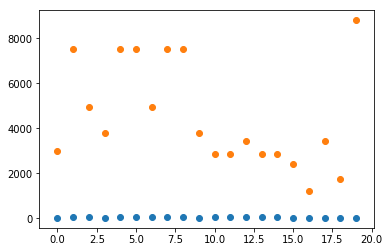

In [8]:
import matplotlib.pyplot as plt

df = report_sens.query('algo == "TSens"')
x = df['query']
y = df['sensitivity']
plt.scatter(list(range(len(y))), y)
df = report_sens.query('algo == "Elastic"')
x = df['query']
y = df['sensitivity']
plt.scatter(list(range(len(y))), y)
plt.show()

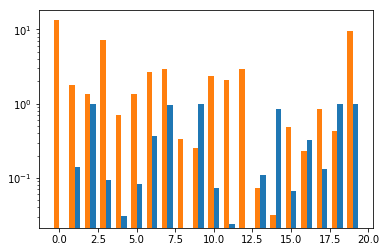

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def show_DP(algo, shift):
    width = 0.35
    df = report_DP
    df['error'] = np.absolute(df['nosy_ans'] - df['true_ans']) / df['true_ans']
    df = df.query('algo == "{algo}"'.format(algo=algo))
    y = df['error']
    plt.bar(np.arange(len(y)) + shift * width, y, width = width)
    #plt.scatter(np.arange(len(y)), y)
    
plt.yscale('log')
show_DP('TSensDP', 0.5)
show_DP('PrivateSQL', -0.5)
plt.show()